In [1]:
#!/usr/bin/env python3
"""
Genera:
  • summary_scenarios.csv  –  métrica global por escenario
  • mt_distribution.csv    –  |mt| de cada par descoordinado
Notas:
  – TMT se define como la suma de mt (siempre negativo) y es adimensional.
  – CTI fijo en 0.2 s.
"""
import json, csv, os
CTI = 0.2
INPUT_FILE = "/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/independent_relay_pairs_transformer.json"
OUT_CSV_SCEN = "summary_scenarios_transformer.csv"
OUT_CSV_MT   = "mt_distribution_transformer.csv"

with open(INPUT_FILE) as f:
    data = json.load(f)

per_scenario = {}
for p in data:
    sid = p["scenario_id"]
    d = per_scenario.setdefault(sid, {"total":0,"valid":0,"descoord":0,"TMT":0.0})
    d["total"] += 1
    tm, tb = p["main_relay"].get("Time_out"), p["backup_relay"].get("Time_out")
    if not all(isinstance(x,(int,float)) for x in (tm, tb)):
        continue
    d["valid"] += 1
    delta_t = tb - tm - CTI
    mt = (delta_t - abs(delta_t))/2        # negativo si Δt<0
    if delta_t < 0:
        d["descoord"] += 1
        d["TMT"]      += mt                # suma valores negativos
        # exportar |mt| para gráfica de distribución
        with open(OUT_CSV_MT,"a",newline="") as g:
            csv.writer(g).writerow([
                sid,
                f'{p["fault"]}% {p["main_relay"]["relay"]}/{p["backup_relay"]["relay"]}',
                abs(mt)
            ])

with open(OUT_CSV_SCEN,"w",newline="") as f:
    w = csv.writer(f)
    w.writerow(["Escenario","Pares evaluados","Pares válidos",
                "Descoordinados","% Descoord","TMT (negativo)"])
    for sid,d in sorted(per_scenario.items(),
                        key=lambda k:int(k[0].split("_")[-1])):
        pct = 100*d["descoord"]/d["valid"] if d["valid"] else 0
        w.writerow([sid,d["total"],d["valid"],d["descoord"],
                    f"{pct:.1f}",f"{d['TMT']:.5f}"])
print("✓ summary_scenarios.csv y mt_distribution.csv listos")


✓ summary_scenarios.csv y mt_distribution.csv listos


# graph


In [2]:
#!/usr/bin/env python3
"""
Lee summary_scenarios.csv y genera:
  • tmt_by_scenario.png  –  gráfica en barras del TMT (negativo)
"""
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Cargar CSV ---
df = pd.read_csv("summary_scenarios_transformer.csv")

# --- 2. Extraer número de escenario y ordenar ---
df["num"] = pd.to_numeric(df["Escenario"].str.extract(r"(\d+)")[0])
df = df.sort_values("num")

# --- 3. Graficar ---
plt.figure(figsize=(12,5))
plt.bar(df["Escenario"], df["TMT (negativo)"])
plt.title("TMT por escenario (68 escenarios)")
plt.xlabel("Escenario")
plt.ylabel("TMT")
plt.xticks(rotation=90)
plt.tight_layout()

# --- 4. Guardar como PNG (300 dpi) ---
plt.savefig("tmt_by_scenario_transformer.png", dpi=300)
plt.close()

print("✓ tmt_by_scenario_transformer.png generado")


✓ tmt_by_scenario_transformer.png generado


# grap v2

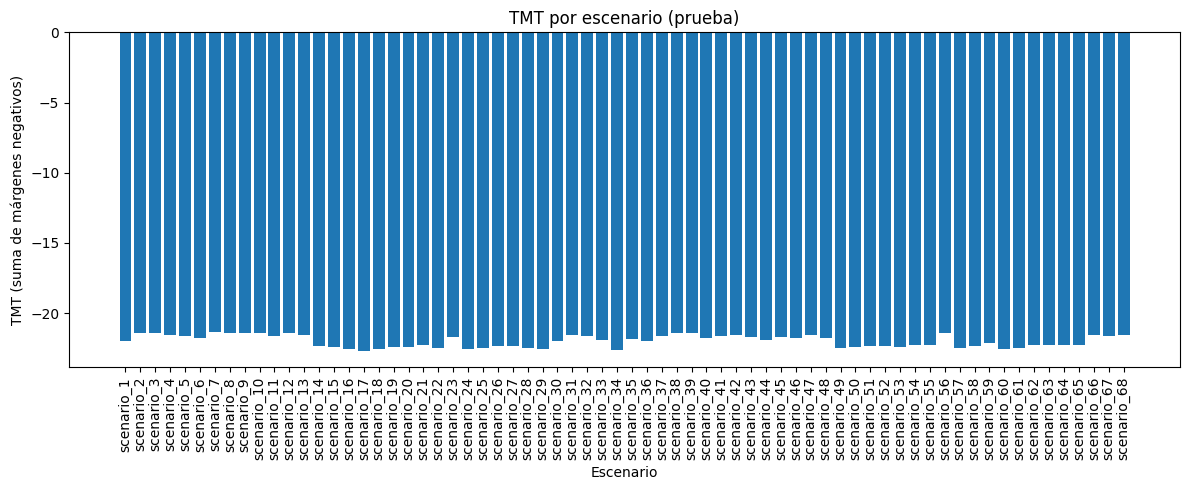

Gráfica guardada en: /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/results/tmt_by_scenario_prueba_v2.png


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Lee TDS_Pickup_nuevos.csv con columnas:
  escenario,par_rele,TDS_principal,Pickup_principal,TDS_respaldo,Pickup_respaldo
Calcula TM = Pickup_respaldo − Pickup_principal − CTI
y agrupa los TM negativos para obtener TMT por escenario.
Dibuja un bar chart de TMT por escenario.
"""

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ─── Configuración de rutas y constantes ────────────────────────────────
BASE   = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/")
CSV_IN = BASE / "data/processed/model/results/TDS_Pickup_nuevos.csv"
PNG_OUT = BASE / "data/processed/model/results/tmt_by_scenario_prueba_v2.png"
CTI    = 0.2

# ─── 1) Cargar CSV ───────────────────────────────────────────────────────
df = pd.read_csv(CSV_IN)

# ─── 2) Calcular TM (margen de tiempo usando pickup) ────────────────────
# df["TM"] = df["Pickup_respaldo"] - df["Pickup_principal"] - CTI
#2) Calcular TM (margen de tiempo usando time out)


# ─── 3) Agrupar para obtener TMT (suma de TM negativos) ─────────────────
summary = (
    df.groupby("escenario")["TM"]
      .apply(lambda x: x[x < 0].sum())
      .reset_index()
      .rename(columns={"TM": "TMT (negativo)"})
)

# Extraer número de escenario para ordenarlo
summary["num"] = summary["escenario"].str.extract(r"(\d+)").astype(int)
summary = summary.sort_values("num")

# ─── 4) Gráfica de barras ───────────────────────────────────────────────
plt.figure(figsize=(12, 5))
plt.bar(summary["escenario"], summary["TMT (negativo)"])
plt.title("TMT por escenario (prueba)")
plt.xlabel("Escenario")
plt.ylabel("TMT (suma de márgenes negativos)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(PNG_OUT, dpi=300)
plt.show()

print(f"Gráfica guardada en: {PNG_OUT}")


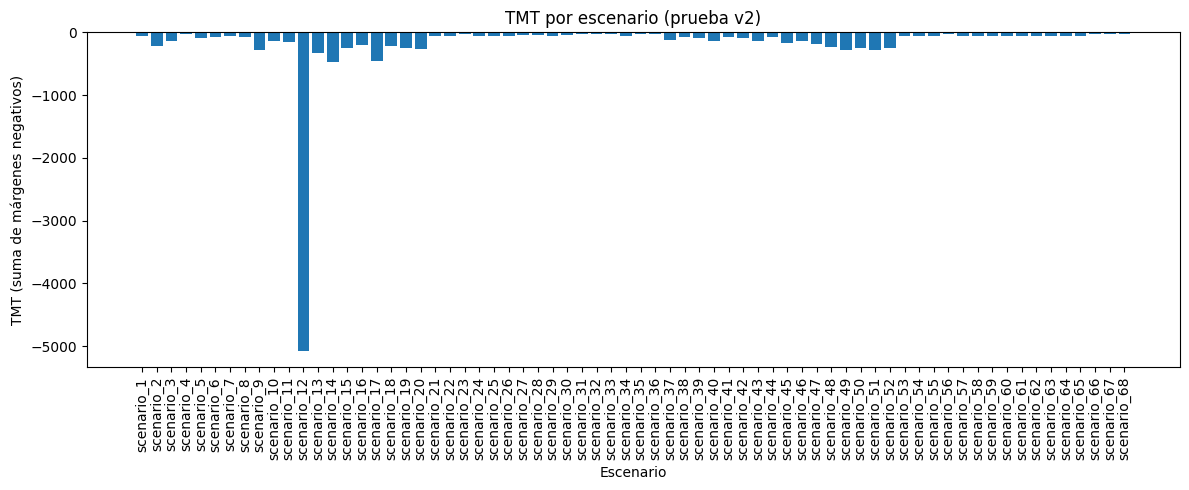

Gráfica guardada en: /Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/data/processed/model/results/tmt_by_scenario_prueba_v2.png


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Lee los nuevos ajustes de TDS/pickup, recalcula Time_out con la función
calculate_operation_time, obtiene delta_t y mt para cada par, agrupa
los mt negativos en TMT por escenario y dibuja un bar chart.
"""

import json
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from pathlib import Path

# ─────────────────────────── CONSTANTES ───────────────────────────
K = 0.14
N = 0.02
DECIMAL_PLACES = 4
CTI = 0.2

def calculate_operation_time(I_shc, I_pi, TDS):
    if not all(isinstance(x, (int, float)) for x in [I_shc, I_pi, TDS]):
        return 0.0
    if any(x is None or x <= 0 for x in [I_pi, TDS]) or I_shc <= 0:
        return 0.0
    try:
        if abs(I_pi) < 1e-9:
            return 0.0
        M = I_shc / I_pi
    except ZeroDivisionError:
        return 0.0
    if M <= 1:
        return 0.0
    try:
        denominator = M**N - 1
        if abs(denominator) < 1e-9:
            return 0.0
        timeout = (K / denominator) * TDS
        return round(timeout, DECIMAL_PLACES) if np.isfinite(timeout) else 0.0
    except (OverflowError, ValueError):
        return 0.0

# ─────────────────────────── RUTAS ───────────────────────────
BASE    = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/")
JSON_IN = BASE / "data/processed/independent_relay_pairs_transformer.json"
CSV_IN  = BASE / "data/processed/model/results/TDS_Pickup_nuevos.csv"
PNG_OUT = BASE / "data/processed/model/results/tmt_by_scenario_prueba_v2.png"

# ────────────────── 1) Carga de pares originales ──────────────────
with open(JSON_IN, "r") as f:
    pairs = json.load(f)

# Asignar par_rele en orden de aparición
counts = {}
for pair in pairs:
    sid = pair["scenario_id"]
    counts[sid] = counts.get(sid, 0) + 1
    pair["par_rele"] = counts[sid]

# ────────────────── 2) Leer CSV y construir mapa de ajustes ────────
df_new = pd.read_csv(CSV_IN)
new_map = {
    (row["escenario"], row["par_rele"]): row.to_dict()
    for _, row in df_new.iterrows()
}

# ────────────────── 3) Recalcular timeouts y márgenes ────────────
for pair in pairs:
    key = (pair["scenario_id"], pair["par_rele"])
    ajustes = new_map.get(key)

    main = pair["main_relay"]
    back = pair["backup_relay"]

    if ajustes:
        main["TDS"]     = ajustes["TDS_principal"]
        main["pick_up"] = ajustes["Pickup_principal"]
        back["TDS"]     = ajustes["TDS_respaldo"]
        back["pick_up"] = ajustes["Pickup_respaldo"]

    main_time   = calculate_operation_time(main.get("Ishc"), main.get("pick_up"), main.get("TDS"))
    back_time   = calculate_operation_time(back.get("Ishc"), back.get("pick_up"), back.get("TDS"))
    pair["main_time"]   = main_time
    pair["backup_time"] = back_time

    delta_t = back_time - main_time - CTI
    mt = (delta_t - abs(delta_t)) / 2
    pair["delta_t"] = delta_t
    pair["mt"]      = mt

# ────────────────── 4) Agregar mt negativo a TMT por escenario ──────
per_scenario = {}
for p in pairs:
    sid = p["scenario_id"]
    d = per_scenario.setdefault(sid, {"TMT": 0.0})
    mt = p.get("mt", 0.0)
    if isinstance(mt, float) and mt < 0:
        d["TMT"] += mt

# ────────────────── 5) Construir DataFrame de resumen ───────────────
summary = [
    {"Escenario": sid, "TMT (negativo)": vals["TMT"]}
    for sid, vals in sorted(per_scenario.items(),
                            key=lambda x: int(x[0].split("_")[-1]))
]
df_summary = pd.DataFrame(summary)

# ────────────────── 6) Graficar TMT por escenario ────────────────────
plt.figure(figsize=(12,5))
plt.bar(df_summary["Escenario"], df_summary["TMT (negativo)"])
plt.title("TMT por escenario (prueba v2)")
plt.xlabel("Escenario")
plt.ylabel("TMT (suma de márgenes negativos)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(PNG_OUT, dpi=300)
plt.show()

print(f"Gráfica guardada en: {PNG_OUT}")


In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Calcula Time_out, delta_t y mt para cada par, suma los mt negativos
en TMT por escenario y dibuja un bar chart interactivo con Plotly.
"""

import json
import numpy as np
import pandas as pd
import copy
import plotly.express as px
from pathlib import Path

# ─────────────────────────── CONSTANTES ───────────────────────────
K = 0.14
N = 0.02
DECIMAL_PLACES = 4
CTI = 0.2

def calculate_operation_time(I_shc, I_pi, TDS):
    if not all(isinstance(x, (int, float)) for x in (I_shc, I_pi, TDS)):
        return 0.0
    if any(x is None or x <= 0 for x in (I_pi, TDS)) or I_shc <= 0:
        return 0.0
    try:
        if abs(I_pi) < 1e-9:
            return 0.0
        M = I_shc / I_pi
    except ZeroDivisionError:
        return 0.0
    if M <= 1:
        return 0.0
    try:
        denom = M**N - 1
        if abs(denom) < 1e-9:
            return 0.0
        t = (K / denom) * TDS
        return round(t, DECIMAL_PLACES) if np.isfinite(t) else 0.0
    except (OverflowError, ValueError):
        return 0.0

# ─────────────────────────── RUTAS ───────────────────────────
BASE    = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/")
JSON_IN = BASE / "data/processed/independent_relay_pairs_transformer.json"
CSV_IN  = BASE / "data/processed/model/results/TDS_Pickup_nuevos.csv"
HTML_OUT = BASE / "data/processed/model/results/tmt_by_scenario_prueba_v2.html"
PNG_OUT  = BASE / "data/processed/model/results/tmt_by_scenario_prueba_v2.png"

# ────────────────── 1) Leer pares originales ──────────────────
with open(JSON_IN, "r") as f:
    pairs = json.load(f)

# Asignar par_rele en orden de aparición
counts = {}
for pair in pairs:
    sid = pair["scenario_id"]
    counts[sid] = counts.get(sid, 0) + 1
    pair["par_rele"] = counts[sid]

# ──────────────── 2) Leer CSV de nuevos ajustes ───────────────
df_new = pd.read_csv(CSV_IN)
new_map = {
    (int(r["escenario"].split("_")[-1]), r["par_rele"]): r.to_dict()
    for _, r in df_new.iterrows()
}

#


In [10]:
import json
import numpy as np
import pandas as pd
import plotly.express as px
from pathlib import Path

# ─────────────────────────── CONSTANTES ───────────────────────────
K = 0.14
N = 0.02
DECIMAL_PLACES = 4
CTI = 0.2

def calculate_operation_time(I_shc, I_pi, TDS):
    if not all(isinstance(x, (int, float)) for x in (I_shc, I_pi, TDS)):
        return 0.0
    if any(x is None or x <= 0 for x in (I_pi, TDS)) or I_shc <= 0:
        return 0.0
    try:
        if abs(I_pi) < 1e-9:
            return 0.0
        M = I_shc / I_pi
    except ZeroDivisionError:
        return 0.0
    if M <= 1:
        return 0.0
    try:
        denom = M**N - 1
        if abs(denom) < 1e-9:
            return 0.0
        timeout = (K / denom) * TDS
        return round(timeout, DECIMAL_PLACES) if np.isfinite(timeout) else 0.0
    except (OverflowError, ValueError):
        return 0.0

# ─────────────────────────── RUTAS ───────────────────────────
BASE    = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/")
JSON_IN = BASE / "data/processed/independent_relay_pairs_transformer.json"
CSV_IN  = BASE / "data/processed/model/results/TDS_Pickup_nuevos.csv"

# ────────────────── 1) Leer pares originales ──────────────────
with open(JSON_IN, "r") as f:
    pairs = json.load(f)

# Asignar par_rele en orden de aparición
counts = {}
for pair in pairs:
    sid = pair["scenario_id"]
    counts[sid] = counts.get(sid, 0) + 1
    pair["par_rele"] = counts[sid]

# ──────────────── 2) Leer CSV de nuevos ajustes ───────────────
df_new = pd.read_csv(CSV_IN)
new_map = {
    (row["escenario"], row["par_rele"]): row.to_dict()
    for _, row in df_new.iterrows()
}

# ──────── 3) Recalcular timeouts y márgenes y agregar mt ────────
per_scenario = {}
for pair in pairs:
    key = (pair["scenario_id"], pair["par_rele"])
    ajustes = new_map.get(key, {})

    main = pair["main_relay"]
    back = pair["backup_relay"]

    # Actualizar configuraciones
    if ajustes:
        main["TDS"]     = ajustes["TDS_principal"]
        main["pick_up"] = ajustes["Pickup_principal"]
        back["TDS"]     = ajustes["TDS_respaldo"]
        back["pick_up"] = ajustes["Pickup_respaldo"]

    # Recalcular Time_out
    mt_main = calculate_operation_time(main.get("Ishc"), main.get("pick_up"), main.get("TDS"))
    mt_back = calculate_operation_time(back.get("Ishc"), back.get("pick_up"), back.get("TDS"))

    # delta_t y mt
    delta_t = mt_back - mt_main - CTI
    mt_val  = (delta_t - abs(delta_t)) / 2

    # Acumular TMT por escenario
    d = per_scenario.setdefault(pair["scenario_id"], 0.0)
    if mt_val < 0:
        per_scenario[pair["scenario_id"]] += mt_val

# ────────────────── 4) Preparar DataFrame de resumen ──────────────
summary_df = pd.DataFrame([
    {"Escenario": esc, "TMT (negativo)": tmt}
    for esc, tmt in per_scenario.items()
])
# Ordenar por número
summary_df["num"] = summary_df["Escenario"].str.extract(r"(\d+)").astype(int)
summary_df = summary_df.sort_values("num")

# ────────────────── 5) Graficar con Plotly ───────────────────────
fig = px.bar(
    summary_df,
    x="Escenario",
    y="TMT (negativo)",
    title="TMT por escenario (Plotly)",
    labels={"TMT (negativo)": "TMT (suma márgenes negativos)"}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Calcula Time_out, delta_t y mt, suma TMT por escenario,
escala como % del total y grafica con Plotly con dtick=10%.
"""

import json
import numpy as np
import pandas as pd
import plotly.express as px
from pathlib import Path

# ─────────────────────────── CONSTANTES ───────────────────────────
K = 0.14
N = 0.02
DECIMAL_PLACES = 4
CTI = 0.2

def calculate_operation_time(I_shc, I_pi, TDS):
    if not all(isinstance(x, (int, float)) for x in (I_shc, I_pi, TDS)):
        return 0.0
    if any(x is None or x <= 0 for x in (I_pi, TDS)) or I_shc <= 0:
        return 0.0
    try:
        if abs(I_pi) < 1e-9:
            return 0.0
        M = I_shc / I_pi
    except:
        return 0.0
    if M <= 1:
        return 0.0
    denom = M**N - 1
    if abs(denom) < 1e-9:
        return 0.0
    timeout = (K / denom) * TDS
    return round(timeout, DECIMAL_PLACES) if np.isfinite(timeout) else 0.0

# ─────────────────────────── RUTAS ───────────────────────────
BASE    = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/")
JSON_IN = BASE / "data/processed/independent_relay_pairs_transformer.json"
CSV_IN  = BASE / "data/processed/model/results/TDS_Pickup_nuevos.csv"

# ────────────────── 1) Leer pares originales ──────────────────
with open(JSON_IN, "r") as f:
    pairs = json.load(f)

# Asignar par_rele en orden de aparición
counts = {}
for p in pairs:
    sid = p["scenario_id"]
    counts[sid] = counts.get(sid, 0) + 1
    p["par_rele"] = counts[sid]

# ──────────────── 2) Leer CSV de nuevos ajustes ───────────────
df_new = pd.read_csv(CSV_IN)
new_map = {
    (row["escenario"], row["par_rele"]): row.to_dict()
    for _, row in df_new.iterrows()
}

# ──────────────── 3) Calcular mt y acumular TMT ───────────────
tmt_map = {}
for p in pairs:
    key = (p["scenario_id"], p["par_rele"])
    adj = new_map.get(key, {})
    m, b = p["main_relay"], p["backup_relay"]

    if adj:
        m["TDS"], m["pick_up"] = adj["TDS_principal"], adj["Pickup_principal"]
        b["TDS"], b["pick_up"] = adj["TDS_respaldo"], adj["Pickup_respaldo"]

    t_main = calculate_operation_time(m["Ishc"], m["pick_up"], m["TDS"])
    t_back = calculate_operation_time(b["Ishc"], b["pick_up"], b["TDS"])
    delta_t = t_back - t_main - CTI
    mt      = (delta_t - abs(delta_t)) / 2

    if mt < 0:
        tmt_map[p["scenario_id"]] = tmt_map.get(p["scenario_id"], 0.0) + mt

# ────────────────── 4) Preparar DataFrame y escalar ──────────────
df = (
    pd.DataFrame([
        {"Escenario": sid, "TMT (negativo)": tmt}
        for sid, tmt in tmt_map.items()
    ])
)
# porcentaje de cada TMT respecto al total absoluto
total_abs = df["TMT (negativo)"].abs().sum()
df["% del total"] = df["TMT (negativo)"].abs() / total_abs * 100

# extraer número para ordenar
df["num"] = df["Escenario"].str.extract(r"(\d+)").astype(int)
df = df.sort_values("num")

# ────────────────── 5) Graficar con Plotly ───────────────────────
fig = px.bar(
    df,
    x="Escenario",
    y="% del total",
    title="Contribución % de TMT por escenario",
    labels={"% del total": "% del TMT total (negativo)"}
)
fig.update_layout(
    yaxis=dict(tickmode="linear", tick0=0, dtick=10, ticksuffix="%"),
    xaxis_tickangle=-45,
)
# mostrar en notebook o guardarlo:
fig.show()
# fig.write_html(str(BASE / "data/processed/model/results/tmt_pct_plotly.html"))


In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Calcula Time_out, delta_t y mt, suma TMT por escenario,
escala cada TMT real = TMT * 0.1 y grafica con Plotly.
"""

import json
import numpy as np
import pandas as pd
import plotly.express as px
from pathlib import Path

# ─────────────────────────── CONSTANTES ───────────────────────────
K = 0.14
N = 0.02
DECIMAL_PLACES = 4
CTI = 0.2
ESCALA = 0.1   # factor de escala para TMT

def calculate_operation_time(I_shc, I_pi, TDS):
    if not all(isinstance(x, (int, float)) for x in (I_shc, I_pi, TDS)):
        return 0.0
    if any(x is None or x <= 0 for x in (I_pi, TDS)) or I_shc <= 0:
        return 0.0
    try:
        if abs(I_pi) < 1e-9:
            return 0.0
        M = I_shc / I_pi
    except:
        return 0.0
    if M <= 1:
        return 0.0
    denom = M**N - 1
    if abs(denom) < 1e-9:
        return 0.0
    timeout = (K / denom) * TDS
    return round(timeout, DECIMAL_PLACES) if np.isfinite(timeout) else 0.0

# ─────────────────────────── RUTAS ───────────────────────────
BASE    = Path("/Users/gustavo/Documents/Projects/TESIS_UNAL/ADAPTIVE_ALGORITHM/")
JSON_IN = BASE / "data/processed/independent_relay_pairs_transformer.json"
CSV_IN  = BASE / "data/processed/model/results/TDS_Pickup_nuevos.csv"

# ────────────────── 1) Leer pares originales ──────────────────
with open(JSON_IN, "r") as f:
    pairs = json.load(f)

# Asignar par_rele en orden de aparición
counts = {}
for p in pairs:
    sid = p["scenario_id"]
    counts[sid] = counts.get(sid, 0) + 1
    p["par_rele"] = counts[sid]

# ──────────────── 2) Leer CSV de nuevos ajustes ───────────────
df_new = pd.read_csv(CSV_IN)
new_map = {
    (row["escenario"], row["par_rele"]): row.to_dict()
    for _, row in df_new.iterrows()
}

# ──────────────── 3) Calcular mt y acumular TMT ───────────────
tmt_map = {}
for p in pairs:
    key = (p["scenario_id"], p["par_rele"])
    adj = new_map.get(key, {})
    m, b = p["main_relay"], p["backup_relay"]

    if adj:
        m["TDS"], m["pick_up"] = adj["TDS_principal"], adj["Pickup_principal"]
        b["TDS"], b["pick_up"] = adj["TDS_respaldo"], adj["Pickup_respaldo"]

    t_main = calculate_operation_time(m["Ishc"], m["pick_up"], m["TDS"])
    t_back = calculate_operation_time(b["Ishc"], b["pick_up"], b["TDS"])
    delta_t = t_back - t_main - CTI
    mt      = (delta_t - abs(delta_t)) / 2

    if mt < 0:
        tmt_map[p["scenario_id"]] = tmt_map.get(p["scenario_id"], 0.0) + mt

# ────────────────── 4) Preparar DataFrame y escalar ──────────────
df = pd.DataFrame([
    {"Escenario": sid, "TMT (negativo)": tmt}
    for sid, tmt in tmt_map.items()
])
# Escalar:
df["TMT_real"] = df["TMT (negativo)"] * ESCALA

# Ordenar por número
df["num"] = df["Escenario"].str.extract(r"(\d+)").astype(int)
df = df.sort_values("num")

# ────────────────── 5) Graficar con Plotly ───────────────────────
fig = px.bar(
    df,
    x="Escenario",
    y="TMT_real",
    title="TMT real por escenario (escalado x0.1)",
    labels={"TMT_real": "TMT real (TMT × 0.1)"}
)
fig.update_layout(
    yaxis=dict(tickmode="linear", tick0=0, dtick=0.1),
    xaxis_tickangle=-45,
)
fig.show()

# Opcional: guardar como HTML
# fig.write_html(str(BASE / "data/processed/model/results/tmt_real_plotly.html"))
